# Classification: Parliament Members
---
Libraries:

In [1]:
import pandas as pd
import numpy as np
import spacy

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Functions:

In [2]:
# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

# NLP Functions
nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]


Load Dataset:

In [3]:
validation_set = pd.read_csv('../../../datasets/Greek Politicians/classification/parliament_members_validation_set.csv')
validation_set = validation_set.replace(np.nan, '')
validation_set.head()

,screen_name,name,description,statuses_count,recent_100_tweets,friends_count,recent_100_friends_nd,followers_count,default_profile_image,favourites_count,parliament_member,friends_politician_count_1000,followers_politician_count_1000,mentions_politician_count
0,papakostakater,ΚΑΤΕΡΙΝΑ ΠΑΠΑΚΩΣΤΑ - ΠΑΛΙΟΥΡΑ,Δικηγόρος ~ \nΒουλευτής Νέας Δημοκρατίας Νομού...,77,RT @MarkopoulosChTh: The ReMARKables: Η Βουλε...,202,Markopoulos_Ch_Th | BA Communication Speciali...,159,False,94,1,98,13.0,0
1,raptizoi,Ζωή Ράπτη,"Υφυπουργός Υγείας, Bουλευτής Β1 Βορείου Τομέα ...",1891,RT @MegaTvOfficial: Πολιτική αντιπαράθεση για...,861,"Kamala Harris Fighting for the people. Wife, ...",2667,False,4252,1,251,4.0,50
2,nkerameus,Niki Kerameus,"Υπουργός Παιδείας και Θρησκευμάτων, Βουλευτής ...",5135,Ένα είναι το μήνυμα της σημερινής ημέρας προς...,714,European Commission 🇪🇺 News and information f...,40000,False,2809,1,202,0.0,32
3,AndreasPoulas,Ανδρέας Πουλάς,Βουλευτής Ν. Αργολίδας - ΚΙΝΗΜΑ ΑΛΛΑΓΗΣ,326,RT @amna_news: .@AndreasPoulas (#ΚΙΝΑΛ): «Πολ...,99,Aggelos Gavris Αρχισυντάκτης / ιδιοκτήτης @Th...,389,False,200,1,43,9.0,22
4,Dora_Bakoyannis,Ντόρα Μπακογιάννη,To λογαριασμό συνήθως χειρίζεται συνεργάτης μο...,13916,Συνέντευξη Ντόρας Μπακογιάννη στον @SkaitvGR ...,6825,Michael Bertakis 36 years old Work Provisions...,155118,False,3184,1,103,0.0,6


In [4]:
# Variable to Hold predicted labels 
predictions = pd.DataFrame()
predictions['screen_name'] = validation_set['screen_name']
predictions['true_label'] = validation_set['parliament_member']

# Case 1: Name and Description of a Node
---

## Classification based on keywords - Without machine learning

In [5]:
# Copy data to new variable
test = validation_set[['screen_name', 'parliament_member']].copy()
test['textdata'] = validation_set['name'] + ' ' + validation_set['description']

# Process text
test['textdata'] = clean_text(test['textdata'])

predicted_labels = list(test['textdata'].str.contains(r"υπουργός|βουλευτής"))
predicted_labels = list(map(int, predicted_labels)) 
target_names = ['Not-Parliament-Member', 'Parliament-Member']
print(classification_report(y_true = test.parliament_member, y_pred=predicted_labels))
print(confusion_matrix(y_true= test.parliament_member, y_pred=predicted_labels))

del test

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        50
           1       1.00      0.76      0.86        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100

[[50  0]
 [12 38]]


## Classification Using Machine Learning

                       precision    recall  f1-score   support

Not-Parliament-Member       0.88      0.98      0.92        50
    Parliament-Member       0.98      0.86      0.91        50

             accuracy                           0.92       100
            macro avg       0.93      0.92      0.92       100
         weighted avg       0.93      0.92      0.92       100



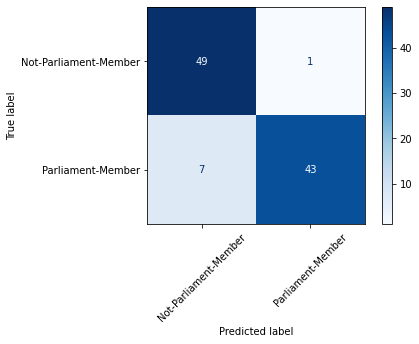

In [6]:
def get_text_data_nd(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata

# Load the model
model_nd = joblib.load('classifiers/classifier_politician_nd.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_nd.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_nd, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

In [7]:
predictions['nd'] = predicted_labels

# Case 2: Recent 100 Tweets of a Node
---

## Only Tweets

                       precision    recall  f1-score   support

Not-Parliament-Member       0.96      0.86      0.91        50
    Parliament-Member       0.87      0.96      0.91        50

             accuracy                           0.91       100
            macro avg       0.91      0.91      0.91       100
         weighted avg       0.91      0.91      0.91       100



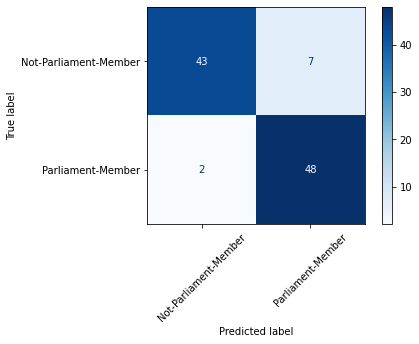

In [8]:
def get_text_data_t(df):
    df['textdata'] = clean_text(df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata


# Load the model
model_t = joblib.load('classifiers/classifier_politician_t.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_t.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_t, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['t'] = predicted_labels

## Name, Description and Tweets

                       precision    recall  f1-score   support

Not-Parliament-Member       0.94      0.92      0.93        50
    Parliament-Member       0.92      0.94      0.93        50

             accuracy                           0.93       100
            macro avg       0.93      0.93      0.93       100
         weighted avg       0.93      0.93      0.93       100



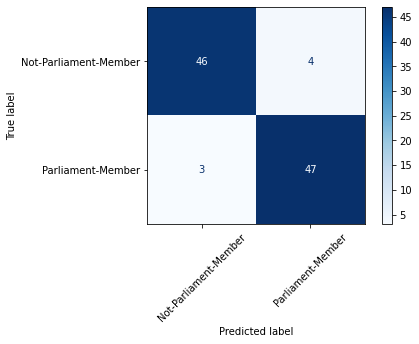

In [9]:
def get_text_data_ndt(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'] + ' ' + df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata

# Load the model
model_ndt = joblib.load('classifiers/classifier_politician_ndt.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_ndt.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_ndt, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['ndt'] = predicted_labels

# Case 3: Parliament Member Friends Count

## Only Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.83      0.80      0.82        50
    Parliament-Member       0.81      0.84      0.82        50

             accuracy                           0.82       100
            macro avg       0.82      0.82      0.82       100
         weighted avg       0.82      0.82      0.82       100



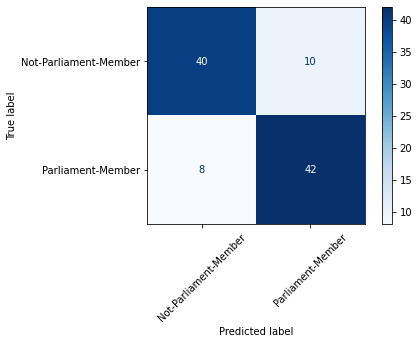

In [10]:
# Function to select the data
def get_data_(df):
    data = df['friends_politician_count_1000'].to_numpy()
    return data.reshape(-1,1)

# Load the model
model_fr = joblib.load('classifiers/classifier_politician_fr.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_fr.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_fr, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['fr'] = predicted_labels

## Name Description Tweets Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.95      0.82      0.88        50
    Parliament-Member       0.84      0.96      0.90        50

             accuracy                           0.89       100
            macro avg       0.90      0.89      0.89       100
         weighted avg       0.90      0.89      0.89       100



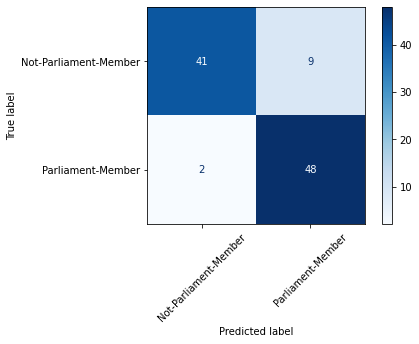

In [11]:
def get_text_data_(df):
    df = df.copy()
    df['textdata'] = clean_text(df['name']+ ' ' + df['description'] + ' ' + df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata

def get_numeric_data_(df):
    data = df['friends_politician_count_1000'].to_numpy()
    return data.reshape(-1,1)


# Load the model
model_ndtfr = joblib.load('classifiers/classifier_politician_ndtfr.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_ndtfr.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_ndtfr, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['ndtfr'] = predicted_labels

# Case 4: Parliament Member Followers Count

## Only Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.76      0.74      0.75        50
    Parliament-Member       0.75      0.76      0.75        50

             accuracy                           0.75       100
            macro avg       0.75      0.75      0.75       100
         weighted avg       0.75      0.75      0.75       100



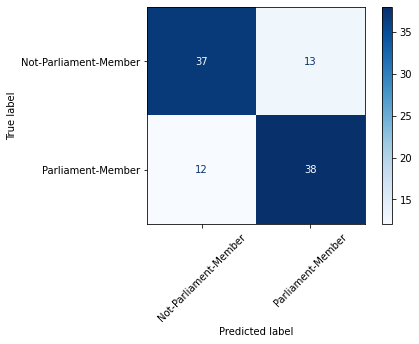

In [12]:
# Function to select the data
def get_data_(df):
    data = df['followers_politician_count_1000'].to_numpy()
    return data.reshape(-1,1)

# Load the model
model_fo = joblib.load('classifiers/classifier_politician_fo.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_fo.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_fo, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['fo'] = predicted_labels

## Friends and Followers Parliament member Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.88      0.86      0.87        50
    Parliament-Member       0.86      0.88      0.87        50

             accuracy                           0.87       100
            macro avg       0.87      0.87      0.87       100
         weighted avg       0.87      0.87      0.87       100



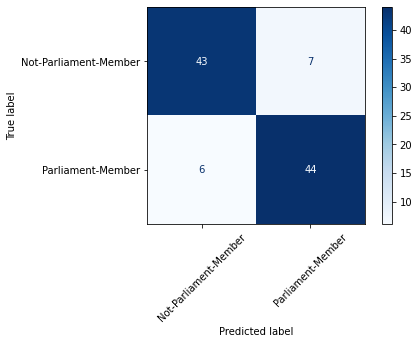

In [13]:
# Function to select the data
def get_data_(df):
    data = df[['friends_politician_count_1000', 'followers_politician_count_1000']].to_numpy()
    return data

# Load the model
model_frfo = joblib.load('classifiers/classifier_politician_frfo.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_frfo.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_frfo, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['frfo'] = predicted_labels

## Name Description Tweets Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.90      0.94      0.92        50
    Parliament-Member       0.94      0.90      0.92        50

             accuracy                           0.92       100
            macro avg       0.92      0.92      0.92       100
         weighted avg       0.92      0.92      0.92       100



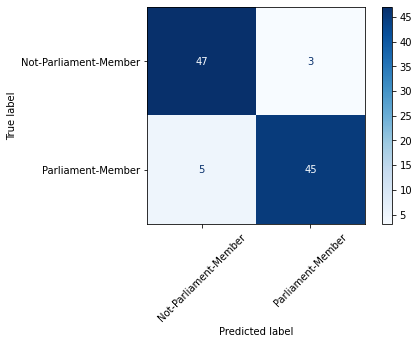

In [14]:
def get_text_data_(df):
    df = df.copy()
    df['textdata'] = clean_text(df['name']+ ' ' + df['description'] + ' ' + df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata


def get_numeric_data_(df):
    data = df[['friends_politician_count_1000', 'followers_politician_count_1000']].to_numpy()
    return data


# Load the model
model_ndtfrfo = joblib.load('classifiers/classifier_politician_ndtfrfo.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_ndtfrfo.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_ndtfrfo, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['ndtfrfo'] = predicted_labels

# Case 4: Parliament Member Mentions Count

## Only Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.75      0.82      0.78        50
    Parliament-Member       0.80      0.72      0.76        50

             accuracy                           0.77       100
            macro avg       0.77      0.77      0.77       100
         weighted avg       0.77      0.77      0.77       100



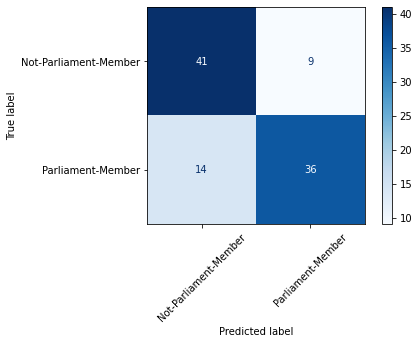

In [15]:
# Function to select the data
def get_data_(df):
    data = df['mentions_politician_count'].to_numpy()
    return data.reshape(-1,1)

# Load the model
model_me = joblib.load('classifiers/classifier_politician_me.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_me.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_me, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['me'] = predicted_labels

## Statuses and Mentions

                       precision    recall  f1-score   support

Not-Parliament-Member       0.91      0.98      0.94        50
    Parliament-Member       0.98      0.90      0.94        50

             accuracy                           0.94       100
            macro avg       0.94      0.94      0.94       100
         weighted avg       0.94      0.94      0.94       100



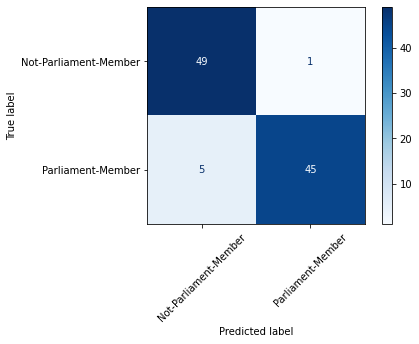

In [16]:
# Function to select the data
def get_text_data_(df):
    df = df.copy()
    df['textdata'] = clean_text(df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata


def get_numeric_data_(df):
    data = df['mentions_politician_count'].to_numpy()
    return data.reshape(-1,1)

# Load the model
model_tme = joblib.load('classifiers/classifier_politician_tme.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_tme.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_tme, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['tme'] = predicted_labels

## Name Description Tweets all Counts

                       precision    recall  f1-score   support

Not-Parliament-Member       0.89      0.98      0.93        50
    Parliament-Member       0.98      0.88      0.93        50

             accuracy                           0.93       100
            macro avg       0.93      0.93      0.93       100
         weighted avg       0.93      0.93      0.93       100



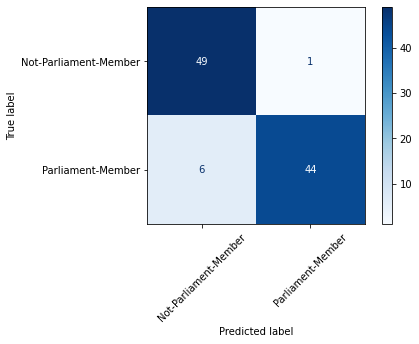

In [17]:
def get_text_data_(df):
    df = df.copy()
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'] + ' ' + df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata


def get_numeric_data_(df):
    data = df[['friends_politician_count_1000', 'followers_politician_count_1000', 'mentions_politician_count']].to_numpy()
    return data


# Load the model
model_ndtfrfome = joblib.load('classifiers/classifier_politician_ndtfrfome.sav')

target_names = ['Not-Parliament-Member', 'Parliament-Member']
predicted_labels = model_ndtfrfome.predict(validation_set)
print(classification_report(y_true = validation_set.parliament_member, y_pred=predicted_labels, target_names=target_names))
plot_confusion_matrix(model_ndtfrfome, validation_set, validation_set.parliament_member, display_labels=target_names, xticks_rotation=45, cmap=plt.cm.Blues)

predictions['ndtfrfome'] = predicted_labels

# Failure Analaysis
---

In [21]:
predictions[(predictions['true_label'] != predictions['nd'])
           |(predictions['true_label'] != predictions['ndt'])
           |(predictions['true_label'] != predictions['ndtfr'])
           |(predictions['true_label'] != predictions['ndtfrfo'])
           |(predictions['true_label'] != predictions['ndtfrfome'])][['screen_name','true_label','nd','ndt','ndtfr','ndtfrfo', 'ndtfrfome']]

,screen_name,true_label,nd,ndt,ndtfr,ndtfrfo,ndtfrfome
0,papakostakater,1,1,0,1,1,1
4,Dora_Bakoyannis,1,0,1,1,1,1
5,GVaremenos,1,1,1,1,0,0
7,tzakri,1,0,0,0,0,0
11,samaras_antonis,1,0,1,1,1,1
16,GVagionas,1,0,1,1,1,1
18,RoussopoulosTh,1,0,0,0,0,0
22,georgantasgr,1,1,1,1,1,0
34,marilizaxen,1,0,1,1,1,1
35,ChStefanadis,1,0,1,1,0,0


In [25]:
predictions[(predictions['true_label'] != predictions['nd'])
           |(predictions['true_label'] != predictions['tme'])
           |(predictions['true_label'] != predictions['fr'])
           |(predictions['true_label'] != predictions['fo'])][['screen_name','true_label','nd','tme','fr','fo']]

,screen_name,true_label,nd,tme,fr,fo
2,nkerameus,1,1,1,1,0
4,Dora_Bakoyannis,1,0,1,1,0
5,GVaremenos,1,1,0,0,1
7,tzakri,1,0,0,0,0
11,samaras_antonis,1,0,1,0,0
13,d_tzanakopoulos,1,1,1,1,0
15,sokrvardakis,1,1,1,0,1
16,GVagionas,1,0,1,1,1
18,RoussopoulosTh,1,0,0,0,1
22,georgantasgr,1,1,1,0,1


In [31]:
predictions[(predictions['true_label'] != predictions['ndtfrfome'])][['screen_name','true_label','ndt', 'ndtfrfome', 'tme']]

,screen_name,true_label,ndt,ndtfrfome,tme
5,GVaremenos,1,1,0,0
7,tzakri,1,0,0,0
18,RoussopoulosTh,1,0,0,0
22,georgantasgr,1,1,0,1
35,ChStefanadis,1,1,0,0
43,YiannisLoverdos,1,1,0,0
55,Georgadas,0,1,1,1
